In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import sklearn

In [3]:
import gc
gc.enable()

In [4]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [5]:
print(test.info())
print(user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB
None


Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientists to work on more high level topics.

In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

You are asked to:
- Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [6]:
test.isna().mean().round(4) * 100

user_id              0.00
date                 0.00
source               0.00
device               0.00
browser_language     0.00
ads_channel         59.88
browser              0.00
conversion           0.00
test                 0.00
dtype: float64

In [7]:
user.isna().mean().round(4) * 100

user_id    0.0
sex        0.0
age        0.0
country    0.0
dtype: float64

In [8]:
test.date.value_counts()
# we can look one day as one test case and then calculate the cvr for
# each test case

2015-12-04    141163
2015-12-03     99493
2015-11-30     71025
2015-12-01     70991
2015-12-02     70649
Name: date, dtype: int64

In [9]:
dat = pd.merge(test, user, how = 'outer', on = 'user_id',
               left_on = None, right_on = None, sort = True, copy = False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [10]:
col_type_dict = {}
dat_dtypes = dat.dtypes.unique()
for each_type in dat_dtypes:
    col_type_dict[each_type] = list(dat.select_dtypes(include = [each_type]).columns)
    print(each_type, len(col_type_dict[each_type]))

int64 3
object 8
float64 1


In [11]:
categorical_cols = col_type_dict[np.dtype('object')]
numerical_cols = col_type_dict[np.dtype('int64')]

In [12]:
def plt_pie_categorical_col(dat, col_in_dat, describe = True): 
    plt.figure(figsize=(5,5))
    dat[str(col_in_dat)].value_counts().plot(kind = 'pie', title = col_in_dat + ' Pie Plot')
    if describe == True:
        print(dat[str(col_in_dat)].describe())
    else:
        pass

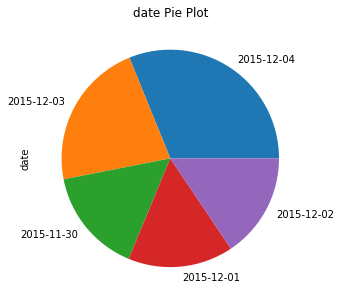

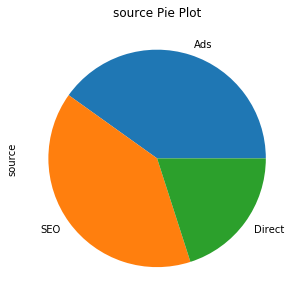

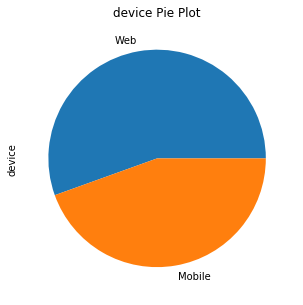

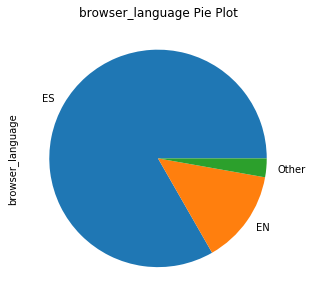

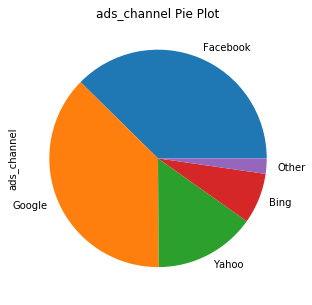

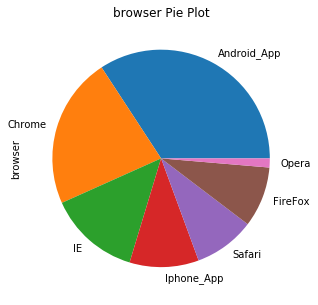

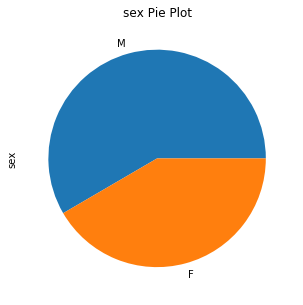

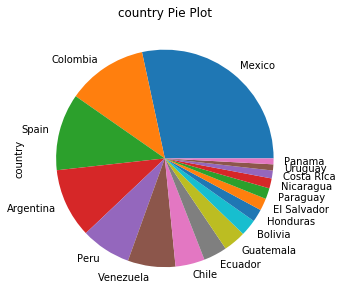

In [13]:
for col in col_type_dict[np.dtype('object')]:
    plt_pie_categorical_col(dat, col, describe=False)

**TO make sure that the A/B test result can be reliable, we should check whether two things:**

**1. the sample of our test data is representive for all the users of our website. And further steps can be taken for this part. For example, there seems to be more men to visit this website than the women.**

**2. Whether there is bias in the segmenetaion of the test and control group. In the ideal world, the distribution of people in test and control for each segment should be the same. [todo] the ways to check this.**

    - One way to check this is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable, you are more likely to end up in test or control, which means bias in segementation.


## check the bias

In [14]:
cvr_by_country = dat['conversion'].groupby(dat['country']).agg('mean').sort_values(ascending = False)
cvr_by_country

country
Spain          0.079719
Costa Rica     0.053494
Nicaragua      0.053399
Colombia       0.051332
El Salvador    0.050765
Mexico         0.050341
Peru           0.050258
Chile          0.049704
Venezuela      0.049666
Guatemala      0.049653
Honduras       0.049253
Ecuador        0.049072
Paraguay       0.048863
Bolivia        0.048634
Panama         0.048089
Argentina      0.013994
Uruguay        0.012821
Name: conversion, dtype: float64

In [15]:
from scipy import stats
x = dat[(dat['country'] != 'Spain') & (dat['test'] == 1)]['conversion']
y = dat[(dat['country'] != 'Spain') & (dat['test'] == 0)]['conversion']
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-7.393937412134479, pvalue=1.428299475405547e-13)

The t-test tell us to reject the null hypothesis, meaning that the test had a very significant effect on conversion.

Plot the cvr of two groups by time, so that we can check weird results have been constantly happening or they just started happening all of a sudden.

In [16]:
cvr_by_group_date = dat[(dat['country'] != 'Spain')]['conversion'].groupby([dat['date'], dat['test']]).agg('mean')
cvr_by_group_date

date        test
2015-11-30  0       0.051378
            1       0.043886
2015-12-01  0       0.046287
            1       0.041387
2015-12-02  0       0.048550
            1       0.044234
2015-12-03  0       0.049284
            1       0.043884
2015-12-04  0       0.047043
            1       0.043491
Name: conversion, dtype: float64

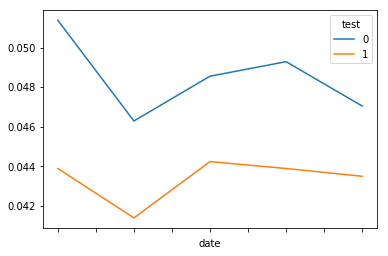

In [17]:
cvr_by_group_date.unstack(level = 1).plot(kind = 'line')

So we can see that the experiment(localized language) group's cvr is always lower than the test(all Spainish). That probably means that we do have enough data, but there was some bias in the experiment set up. We can add more days of running the test. Also, maybe there are bias introduced so that the test/control people are not really random.

In [18]:
from sklearn.preprocessing import LabelEncoder
dat_enc = dat.copy().replace(np.nan, 'NAN', regex = True)
for col in col_type_dict[np.dtype('object')]:
    # print(col)
    lbl_enc = LabelEncoder()
    lbl_enc.fit(dat_enc[col])
    dat_enc[col] = lbl_enc.transform(dat_enc[col])
dat_enc.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2,2,1,0,3,1,0,0,1,38,2
1,2,0,2,0,1,3,0,0,0,1,27,3
2,3,3,2,0,1,3,4,0,1,1,18,7
3,5,0,0,1,1,1,1,0,1,1,22,0
4,8,3,0,0,1,2,0,0,1,1,19,17


c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


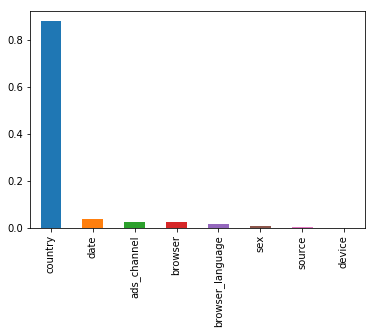

In [19]:
from sklearn.ensemble import RandomForestClassifier
features = col_type_dict[np.dtype('object')]
model = RandomForestClassifier()
model.fit(dat_enc[features], dat_enc['test'])
feature_importance = model.feature_importances_
importance = pd.Series(feature_importance, index = features).sort_values(ascending = False)
importance.plot(kind = 'bar')

It seems that the country variable has a huge difference for deciding the test or control group classifier

In [20]:
dat_test_by_country=dat[dat['country'] != 'Spain']['test'].groupby(dat['country']).agg('value_counts').to_frame()

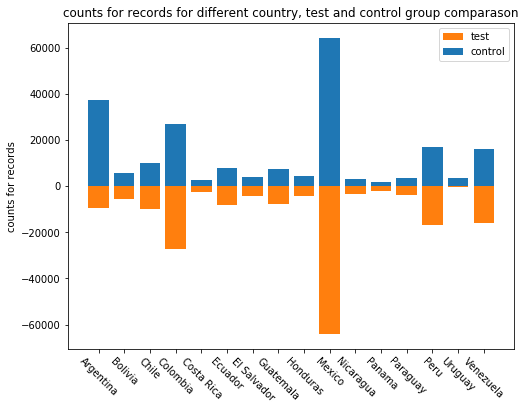

In [24]:
idx = pd.IndexSlice
# dat_test_by_country.loc[idx[['Chile', 'Spain'], :]]
countries_idx = dat_test_by_country.index.get_level_values('country').unique().tolist()
test_1_count = dat_test_by_country.reindex([(i, 1) for i in countries_idx]).test.tolist()
test_0_count = dat_test_by_country.reindex([(i, 0) for i in countries_idx]).test.tolist()
plt.figure(figsize = (8, 6))
p1 = plt.bar(countries_idx, test_1_count)
p0 = plt.bar(countries_idx, np.negative(test_0_count))
plt.ylabel('counts for records')
plt.title('counts for records for different country, test and control group comparason')
plt.xticks(rotation = -45)
plt.legend((p0, p1), ('test', 'control'))

There are way more argentinians and venezuelans in test group than in control group. The rest of the countries seem to have been perfectly randomized


We can however correct our t-test by running a test for every country in order to correct for the bias that over/under-represented countries in each of the experiment gorups have.

In [26]:
for country in dat[dat['country'] != 'Spain'].country.unique():
    print(country)
    x = dat[(dat['country'] == country) & (dat['test'] == 1)]['conversion']
    y = dat[(dat['country'] == country) & (dat['test'] == 0)]['conversion']
    print(stats.ttest_ind(x, y, equal_var = False))

Chile
Ttest_indResult(statistic=1.0303728644383663, pvalue=0.30284764308444684)
Colombia
Ttest_indResult(statistic=-0.7999917822370824, pvalue=0.4237190741314114)
Guatemala
Ttest_indResult(statistic=-0.5649631514620509, pvalue=0.5721072081912069)
Argentina
Ttest_indResult(statistic=-0.9638326839451179, pvalue=0.3351465468746866)
Venezuela
Ttest_indResult(statistic=-0.562614246909357, pvalue=0.5737015234387254)
Paraguay
Ttest_indResult(statistic=0.14628996329799995, pvalue=0.8836965034962364)
Mexico
Ttest_indResult(statistic=1.3866735952325444, pvalue=0.16554372211039656)
Peru
Ttest_indResult(statistic=0.2898235854551192, pvalue=0.7719529885153548)
Bolivia
Ttest_indResult(statistic=-0.35995817724402407, pvalue=0.7188852468451074)
Ecuador
Ttest_indResult(statistic=-0.04825742619891805, pvalue=0.9615116906006622)
Panama
Ttest_indResult(statistic=0.378167043801935, pvalue=0.7053268372725889)
Honduras
Ttest_indResult(statistic=-0.7201328432821794, pvalue=0.47146285652575803)
Nicaragua
Ttest

**Conclusion of the t-tests corrected by segmenting by country:**

After segmenting our experiment data by country, the t-tests are non-significant in every single case. We were not able to improve the conversion, but at least now we know that localized translation does not make the conversion rate worse!